# Virus on a Network

This model replicates the 'virus on a network' model packaged with [Netlogo](http://ccl.northwestern.edu/netlogo/models/). In this notebook, we load up the model, give it some parameters, and collect the results. The model itself is in [model.py](virus_on_network/model.py). We will examine that code in a moment.

First, let's load the model into our notebook:

In [86]:
import networkx
import matplotlib.pyplot as plt
%matplotlib inline

from virus_on_network.model import VirusOnNetwork

In [4]:
# if you get a 'bad magic number' error RUN THIS BLOCK, then rerun the block above
!find . -name '*.pyc' -delete

# the second time you run the first block, you might get a warning about numpy.dtype size changed;
# you can ignore this warning and move on to the block below this one.

# see https://stackoverflow.com/questions/514371/whats-the-bad-magic-number-error

In model.py, there are a number of variables defined, from line 37 onwards:

```
class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(self, num_nodes=10, avg_node_degree=3, initial_outbreak_size=1, virus_spread_chance=0.4,
                virus_check_frequency=0.4, recovery_chance=0.3, gain_resistance_chance=0.5):

```

So while these have defaults, let's set those variables for our run:

In [61]:
model = VirusOnNetwork(num_nodes=5, 
                       avg_node_degree=3, 
                       initial_outbreak_size=1, 
                       virus_spread_chance=0.4,
                       virus_check_frequency=0.4, 
                       recovery_chance=0.3, 
                       gain_resistance_chance=0.5)

That 'self' appears throughout the model. The model creates a randomly wired network of nodes, and each node has an agent, 'self' that checks to see if it is susceptible, or if it is infected, or if it has recovered. Its chances of becoming infected depend on chance and whether or not its linked neighbours are infected.

We run the model, and indicate how many cycles to iterate:

In [62]:
model.run_model(n=10)

...we collect the data...

In [63]:
model_out = model.datacollector.get_model_vars_dataframe()

...and see what we got! How did the virus spread on the social network we built?

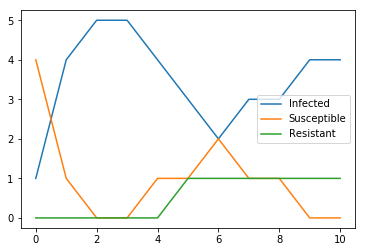

In [64]:
results = model_out.plot()

# Run the network on an actual _observed_ social network

Let's get the ORBIS data from https://raw.githubusercontent.com/sfsheath/gorbit/master/gorbit-edges.csv

In [13]:
!curl https://raw.githubusercontent.com/sfsheath/gorbit/master/gorbit-edges.csv > orbis.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91474  100 91474    0     0   385k      0 --:--:-- --:--:-- --:--:--  385k


In [51]:
import networkx as nx
import pandas as pd

df = pd.read_csv('orbis.csv')
Graphtype = nx.Graph()
ORBIS = nx.from_pandas_edgelist(df, edge_attr='km', create_using=Graphtype)

Let's check to make sure we got the data:

In [52]:
ORBIS.number_of_nodes()


677

In [53]:
ORBIS.number_of_edges()

1104

And we can plot that network

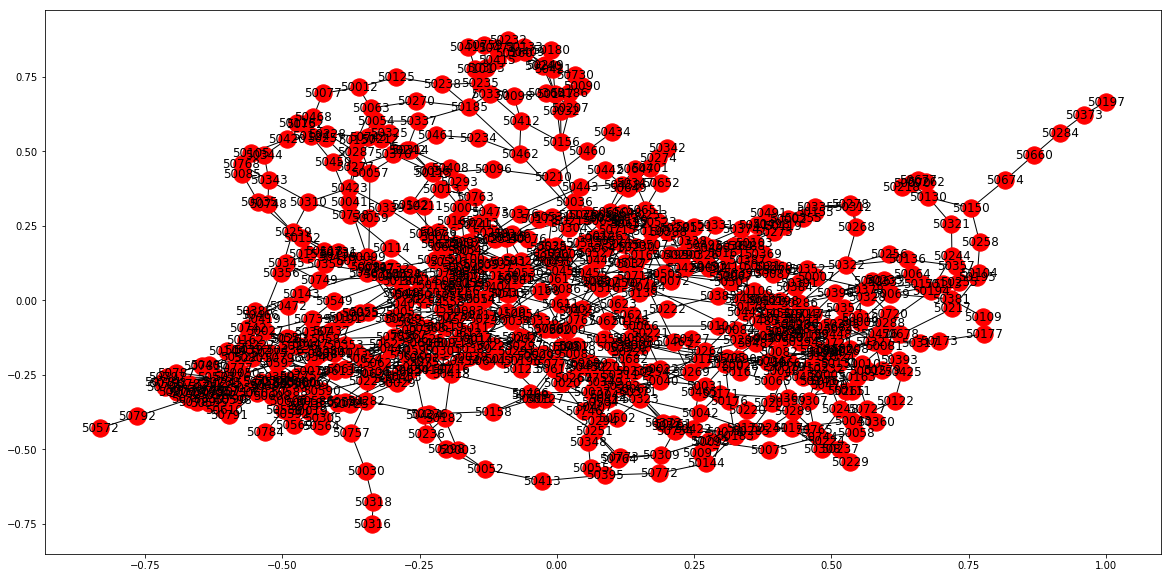

In [66]:
plt.figure(figsize = (20,10))
nx.draw_networkx(ORBIS)
plt.savefig("./map_0.png", format = "png", dpi = 300)
plt.show()

Earlier, we imported the model from the `virus_on_network` folder with `import virus_on_network.model`. This time, let's bring the model into this notebook. We now want it to put agents on those nodes we have above, so we want num_nodes to be whatever the number of nodes is from the ORBIS network; we also want to pass the network graph object to the definitions of the model:

In [67]:
num_nodes = ORBIS.number_of_nodes()

In [214]:
import random
import math
from enum import Enum
import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid


class State(Enum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RESISTANT = 2


def number_state(model, state):
    return sum([1 for a in model.grid.get_all_cell_contents() if a.state is state])


def number_infected(model):
    return number_state(model, State.INFECTED)


def number_susceptible(model):
    return number_state(model, State.SUSCEPTIBLE)


def number_resistant(model):
    return number_state(model, State.RESISTANT)


class VirusOnNetwork2(Model):
    """A virus model with some number of agents"""

    def __init__(self, num_nodes=10, avg_node_degree=3, initial_outbreak_size=1, virus_spread_chance=0.4,
                virus_check_frequency=0.4, recovery_chance=0.3, gain_resistance_chance=0.5):

        self.num_nodes = num_nodes
        # prob = avg_node_degree / self.num_nodes
        self.G = ORBIS #nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = gain_resistance_chance

        self.datacollector = DataCollector({"Infected": number_infected,
                                            "Susceptible": number_susceptible,
                                            "Resistant": number_resistant})

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(i, self, State.SUSCEPTIBLE, self.virus_spread_chance, self.virus_check_frequency,
                           self.recovery_chance, self.gain_resistance_chance)
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes
        infected_nodes = random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = State.INFECTED

        self.running = True
        self.datacollector.collect(self)

    def resistant_susceptible_ratio(self):
        try:
            return number_state(self, State.RESISTANT) / number_state(self, State.SUSCEPTIBLE)
        except ZeroDivisionError:
            return math.inf

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in range(n):
            self.step()


class VirusAgent(Agent):
    def __init__(self, unique_id, model, initial_state, virus_spread_chance, virus_check_frequency,
                 recovery_chance, gain_resistance_chance):
        super().__init__(unique_id, model)

        self.state = initial_state

        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = gain_resistance_chance

    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [agent for agent in self.model.grid.get_cell_list_contents(neighbors_nodes) if
                                 agent.state is State.SUSCEPTIBLE]
        for a in susceptible_neighbors:
            if random.random() < self.virus_spread_chance:
                a.state = State.INFECTED

    def try_gain_resistance(self):
        if random.random() < self.gain_resistance_chance:
            self.state = State.RESISTANT

    def try_remove_infection(self):
        # Try to remove
        if random.random() < self.recovery_chance:
            # Success
            self.state = State.SUSCEPTIBLE
            self.try_gain_resistance()
        else:
            # Failed
            self.state = State.INFECTED

    def try_check_situation(self):
        if random.random() < self.virus_check_frequency:
            # Checking...
            if self.state is State.INFECTED:
                self.try_remove_infection()

    def step(self):
        if self.state is State.INFECTED:
            self.try_to_infect_neighbors()
        self.try_check_situation()

In [215]:
model2 = VirusOnNetwork2( 
                       initial_outbreak_size=1, 
                       virus_spread_chance=0.4,
                       virus_check_frequency=0.4, 
                       recovery_chance=0.3, 
                       gain_resistance_chance=0.5)
model2.run_model(n=10)

In [216]:
model_out2 = model2.datacollector.get_model_vars_dataframe()

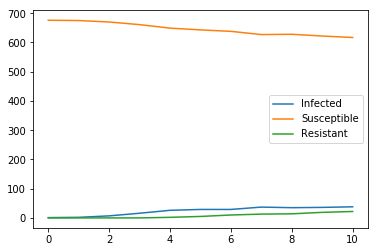

In [337]:
results = model_out2.plot()

Let's do a parameter sweep. We're going to hold most of the variables constant, and explore how the ability to 'gain resistance' to this 'virus' plays out. (If we're modeling the network connections of the Roman world, perhaps the virus is some new idea about, oh, religious practice. Clearly, many things are simplified here, but this *could* be a start to a much more complicated model if desired).

In [393]:
from mesa.batchrunner import BatchRunner
import numpy as np

fixed_params = dict(initial_outbreak_size=1, 
                 virus_spread_chance=0.4,
                   virus_check_frequency=0.4,
                   recovery_chance=0.3)
# Vary density from 0.01 to 1 by increments; np.linspace takes the start, finish, and then
# number of samples to generate. Thus 0,1,50 goes up in 0.02 increments; 0,1,10 would go up by 0.1 :
variable_params = dict(gain_resistance_chance=np.linspace(0,1,10)[1:]
                       )

In [394]:
# At the end of each model run, calculate the number of infected nodes
# these take measurements at the end

model_reporter = {"Susceptible": number_susceptible,
                  "Resistant": number_resistant}

In [401]:
# Create the batch runner; each iteration has 10 settings, so this'll run for 100 iterations
# be patient when you run the next block!
param_run = BatchRunner(VirusOnNetwork2, variable_parameters=variable_params, iterations=10, 
                        fixed_parameters=fixed_params, model_reporters=model_reporter)

In [402]:
param_run.run_all()

90it [09:40,  6.51s/it]


Now we extract the results into a dataframe:

In [403]:
df = param_run.get_model_vars_dataframe()

In [404]:
df.head()

,gain_resistance_chance,Run,Infected,Resistant,Susceptible,initial_outbreak_size,virus_spread_chance,virus_check_frequency,recovery_chance
0,0.111111,0,0,461,216,1,0.4,0.4,0.3
50,0.666667,0,0,584,93,1,0.4,0.4,0.3
30,0.444444,0,0,553,124,1,0.4,0.4,0.3
60,0.777778,0,0,623,54,1,0.4,0.4,0.3
20,0.333333,0,0,517,160,1,0.4,0.4,0.3


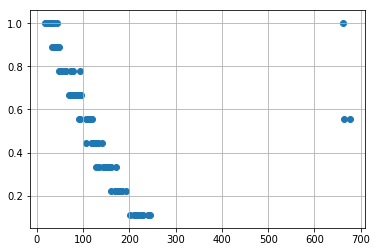

In [405]:
plt.scatter(df.Susceptible, df.gain_resistance_chance)
plt.grid(True)